# Audio Feature Exploration
Load the processed audio tensors and inspect their core properties before deeper modeling.

In [ ]:
!apt install ffmpeg


In [18]:

!pip install gdown
!pip install librosa
!pip install spleeter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [gdown]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 4.5 MB/s  0:00:00m 4.6 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 5.4 MB/s  0:00:10 eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [librosa]━━━ 6/7 [librosa]umba]
  Using cached spleeter-2.1.0-py3-none-any.whl.metadata (10 kB)
  Using cached ffmpeg_python-0.2.0-py3-none-any.whl.metadata (1.7 kB)
  Using cached httpx-0.16.1-py3-none-any.whl.metadata (38 kB)
  Using cached librosa-0.8.0.tar.gz (183 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached norbert-0.2.1-py2.py3-none-any.whl.metadata (3.8 kB)
  Using cached numpy-1.18.5.zip (5.4 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... error
  error: subprocess-exited-with-error
  
  × Preparing

In [ ]:
!wget https://github.com/deezer/spleeter/raw/master/audio_example.mp3

In [ ]:
!spleeter separate -o audio_samples -p spleeter:5stems audio_example.mp3

In [19]:
import pathlib
import numpy as np
import runpy, sys
from preprocess_audio import preprocess_audio
from IPython.display import Audio
import librosa
from scipy.signal import butter, filtfilt
import numpy as np
import os
import matplotlib.pyplot as plt

In [ ]:


# find the bass file in audio_samples (try common extensions)

#    <audiofile>
#       <fileID>B11-28100-3311-00625</fileID>
#       <instrument>B</instrument>
#       <instrumentsetting>1</instrumentsetting>
#       <playstyle>1</playstyle>
#       <midinr>28</midinr>
#       <string>1</string>
#       <fret>00</fret>
#       <fxgroup>3</fxgroup>
#       <fxtype>31</fxtype>
#       <fxsetting>1</fxsetting>
#       <filenr>00625</filenr>
#    </audiofile>


input_path = pathlib.Path("B11-28100-3311-00625.wav")

# target artifact produced by preprocess_audio.py
output_path = pathlib.Path("processed_sample.npz")

# preprocess_audio(args.input, args.output, args.target_samplerate, args.frame_size, args.hop_length)
preprocess_audio(input_path, output_path, 16000, 1024, 512)

print(f"Preprocessed {input_path} -> {output_path}")
artifacts = np.load(output_path)

sample_rate = int(artifacts["sample_rate"])
frame_size = int(artifacts["frame_size"])
hop_length = int(artifacts["hop_length"])
waveform = artifacts["waveform"]
spectrogram = artifacts["magnitude_spectrogram"]
rms = artifacts["rms"]


print(f"Sample rate: {sample_rate} Hz")
print(f"Frame size: {frame_size}")
print(f"Hop length: {hop_length}")
print(f"Waveform duration: {waveform.size / sample_rate:.2f} s")
print(f"Spectrogram shape: {spectrogram.shape}")
print(f"RMS frames: {rms.size}")

Preprocessed B11-28100-3311-00625.wav -> processed_sample.npz
Sample rate: 16000 Hz
Frame size: 1024
Hop length: 512
Waveform duration: 2.00 s
Spectrogram shape: (62, 513)
RMS frames: 62


In [41]:
Audio(input_path)

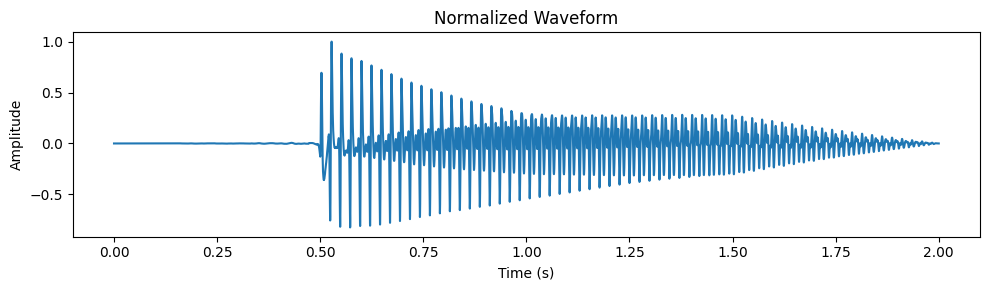

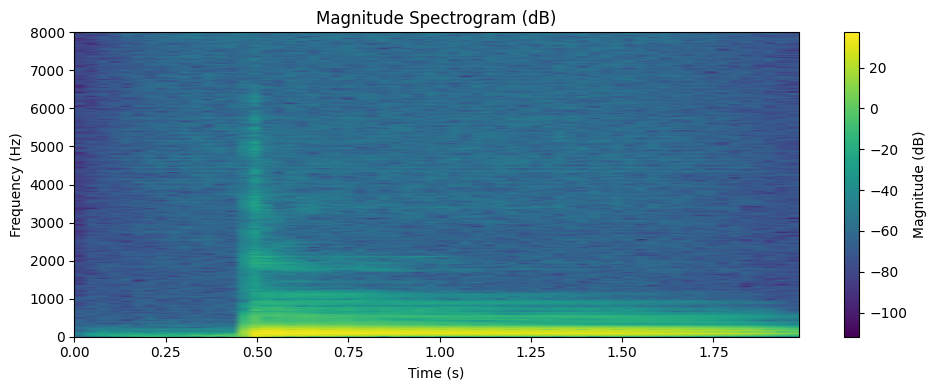

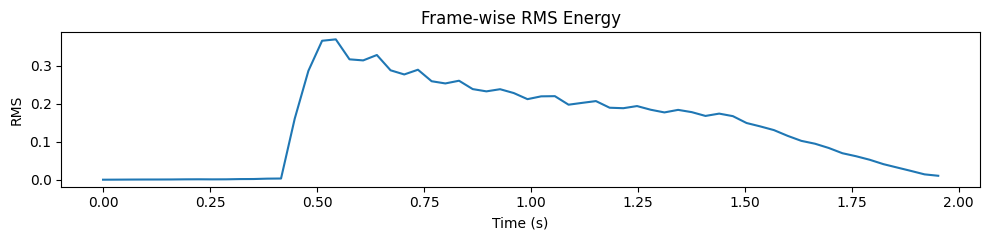

In [42]:
import matplotlib.pyplot as plt

time_axis = np.arange(waveform.size) / sample_rate
plt.figure(figsize=(10, 3))
plt.plot(time_axis, waveform)
plt.title("Normalized Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

time_extent = spectrogram.shape[0] * hop_length / sample_rate
freq_extent = sample_rate / 2
plt.figure(figsize=(10, 4))
plt.imshow(20 * np.log10(np.maximum(spectrogram, 1e-6)).T,
           origin="lower",
           aspect="auto",
           extent=[0, time_extent, 0, freq_extent])
plt.title("Magnitude Spectrogram (dB)")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="Magnitude (dB)")
plt.tight_layout()
plt.show()

frame_times = np.arange(rms.size) * hop_length / sample_rate
plt.figure(figsize=(10, 2.5))
plt.plot(frame_times, rms)
plt.title("Frame-wise RMS Energy")
plt.xlabel("Time (s)")
plt.ylabel("RMS")
plt.tight_layout()
plt.show()

In [43]:
def compute_logmel_spectrogram(y, sr, n_mels=128, hop_length=512):
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length)
    logmel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return logmel_spectrogram


In [47]:
y, sr = librosa.load(output_path, sr=None)

# Compute log-mel spectrogram
logmel_spectrogram = compute_logmel_spectrogram(y, sr=sr)

# Display the log-mel spectrogram
plt.figure(figsize=(8, 4))
librosa.display.specshow(logmel_spectrogram, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-Mel Spectrogram')
plt.show()

/tmp/ipykernel_2330654/3388940281.py:1: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(output_path, sr=None)
/home/julien/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


NoBackendError: 

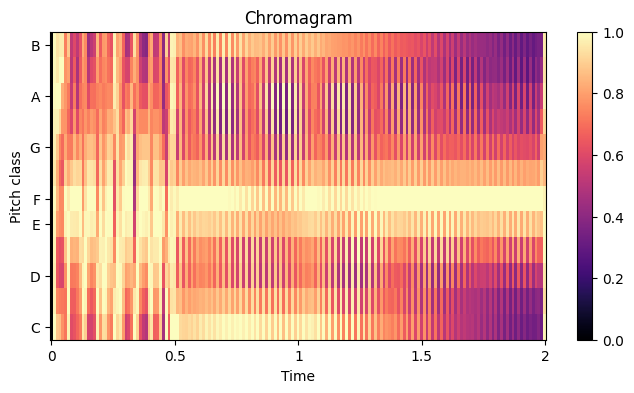

In [45]:
# compute chromagram
chromagram = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=512)
# Display the chromagram
plt.figure(figsize=(8, 4))
librosa.display.specshow(chromagram, sr=sr, hop_length=512, x_axis='time', y_axis='chroma')
plt.colorbar()
plt.title('Chromagram')
plt.show()


In [46]:
# get the best match pitch class for the sample
chroma_mean = np.mean(chromagram, axis=1)
best_pitch_class = np.argmax(chroma_mean)
pitch_classes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
best_pitch = pitch_classes[best_pitch_class]
print(f"The best matching pitch class is: {best_pitch}")

The best matching pitch class is: F
